<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

# Importar os módulos

In [1]:
%load_ext autoreload
%autoreload 2
import os
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline  
import Dataset_transf as dprep
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler


from sklearn import metrics

from sklearn import model_selection

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss, roc_curve, precision_score, recall_score,confusion_matrix,f1_score,fbeta_score, make_scorer


# Obter os dataframes dos ficheiros

In [2]:
failures_df, signals_df, logs_df = dprep.get_data()

In [3]:
df_list = [failures_df, signals_df, logs_df]

# Criação de datasets de components

In [4]:
df_generator, df_gen_bear, df_transformer, df_hydraulic, df_gearbox = dprep.component_df_creation(signals_df)

In [5]:
comp_df_list = [df_generator, df_hydraulic, df_gen_bear, df_transformer,  df_gearbox]

In [6]:
for i in comp_df_list:
    print(i.shape)

(434145, 45)
(434145, 31)
(434145, 45)
(434145, 36)
(434145, 33)


In [7]:
component_list = failures_df.Component.unique()
component_list

array(['GENERATOR', 'HYDRAULIC_GROUP', 'GENERATOR_BEARING', 'TRANSFORMER',
       'GEARBOX'], dtype=object)

# Merge dos DF com o DF de failures

In [8]:
for i in range(len(component_list)):
    comp_df_list[i] = dprep.sig_fail_merge_dfs(sig_df=comp_df_list[i],
                                               fail_df=failures_df,
                                               component=component_list[i])

In [9]:
for i in comp_df_list:
    print(i.shape)

(434147, 46)
(434145, 32)
(434145, 46)
(434145, 37)
(434145, 34)


# Fillna by turbine

In [10]:
turbine_list = signals_df.Turbine_ID.unique()
turbine_list

array(['T11', 'T06', 'T01', 'T09', 'T07'], dtype=object)

In [11]:
for i in range(len(component_list)):
    comp_df_list[i] = dprep.fill_na_by_turbine(comp_df_list[i], turbine_list)

/Users/miguelamaro/code/miguelamaro4/Final_Project/wmillfailprev/notebooks/Dataset_transf.py:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  index['date'] = index['Timestamp']
/Users/miguelamaro/code/miguelamaro4/Final_Project/wmillfailprev/notebooks/Dataset_transf.py:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  index['date'] = index['Timestamp']
/Users/miguelamaro/code/miguelamaro4/Final_Project/wmillfailprev/notebooks/Dataset_transf.py:170: SettingWithCopyWarning: 
A value is trying to be set on 

/Users/miguelamaro/code/miguelamaro4/Final_Project/wmillfailprev/notebooks/Dataset_transf.py:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  index['date'] = index['Timestamp']
/Users/miguelamaro/code/miguelamaro4/Final_Project/wmillfailprev/notebooks/Dataset_transf.py:170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged['date'] = df_merged['Timestamp']
/Users/miguelamaro/code/miguelamaro4/Final_Project/wmillfailprev/notebooks/Dataset_transf.py:171: SettingWithCopyWarning: 
A value is trying to be

In [12]:
for i in comp_df_list:
    print(i.shape)

(434147, 47)
(434145, 33)
(434145, 47)
(434145, 38)
(434145, 35)


# Criação de Variável alvo

In [13]:
for i in range(len(comp_df_list)):
    print(comp_df_list[i].isna().sum().value_counts())

0    47
dtype: int64
0    33
dtype: int64
0    47
dtype: int64
0    38
dtype: int64
0    35
dtype: int64


In [14]:
days_list = [60,30,10]

In [15]:
for day in days_list:
    for i in range(len(comp_df_list)):
        comp_df_list[i] = dprep.aplic_var_target(comp_df_list[i], day)

In [16]:
for i in comp_df_list:
    print(i.shape)

(434147, 50)
(434145, 36)
(434145, 50)
(434145, 41)
(434145, 38)


# Feature selection

In [17]:
for i in comp_df_list:
    print(i.keys())

Index(['Timestamp', 'Turbine_ID', 'Gen_RPM_Max', 'Gen_RPM_Min', 'Gen_RPM_Avg',
       'Gen_RPM_Std', 'Gen_Bear_Temp_Avg', 'Gen_Phase1_Temp_Avg',
       'Gen_Phase2_Temp_Avg', 'Gen_Phase3_Temp_Avg',
       'Prod_LatestAvg_ActPwrGen0', 'Prod_LatestAvg_ActPwrGen1',
       'Prod_LatestAvg_ReactPwrGen0', 'Prod_LatestAvg_ReactPwrGen1',
       'Gen_SlipRing_Temp_Avg', 'Gen_Bear2_Temp_Avg', 'Rtr_RPM_Max',
       'Rtr_RPM_Min', 'Rtr_RPM_Avg', 'Grd_RtrInvPhase1_Temp_Avg',
       'Grd_RtrInvPhase2_Temp_Avg', 'Grd_RtrInvPhase3_Temp_Avg', 'Rtr_RPM_Std',
       'Amb_WindSpeed_Max', 'Amb_WindSpeed_Min', 'Amb_WindSpeed_Avg',
       'Amb_WindSpeed_Std', 'Amb_WindDir_Relative_Avg', 'Amb_WindDir_Abs_Avg',
       'Amb_Temp_Avg', 'Amb_WindSpeed_Est_Avg', 'Blds_PitchAngle_Min',
       'Blds_PitchAngle_Max', 'Blds_PitchAngle_Avg', 'Blds_PitchAngle_Std',
       'Cont_Top_Temp_Avg', 'Cont_Hub_Temp_Avg', 'Cont_VCP_Temp_Avg',
       'Cont_VCP_ChokcoilTemp_Avg', 'Cont_VCP_WtrTemp_Avg', 'Nac_Temp_Avg',
       'Nac

In [18]:
gen_features_drop = [
    'Gen_RPM_Max', 'Gen_RPM_Min', 'Gen_Phase1_Temp_Avg', 'Gen_Phase3_Temp_Avg',
    'Amb_WindSpeed_Est_Avg', 'Grd_RtrInvPhase1_Temp_Avg',
    'Grd_RtrInvPhase3_Temp_Avg', 'Rtr_RPM_Max', 'Rtr_RPM_Min',
    'Blds_PitchAngle_Max', 'Blds_PitchAngle_Min',
    'Prod_LatestAvg_ReactPwrGen1', 'Cont_Hub_Temp_Avg', 'Spin_Temp_Avg',
    'Rtr_RPM_Std', 'Rtr_RPM_Avg', 'Cont_VCP_Temp_Avg'
]

In [19]:
gen_bear_features_drop = [
    'Gen_RPM_Max', 'Gen_RPM_Min', 'Gen_Phase1_Temp_Avg', 'Gen_Phase3_Temp_Avg',
    'Amb_WindSpeed_Est_Avg', 'Grd_RtrInvPhase1_Temp_Avg',
    'Grd_RtrInvPhase3_Temp_Avg', 'Rtr_RPM_Max', 'Rtr_RPM_Min',
    'Blds_PitchAngle_Max', 'Blds_PitchAngle_Min',
    'Prod_LatestAvg_ReactPwrGen1', 'Cont_Hub_Temp_Avg', 'Spin_Temp_Avg',
    'Rtr_RPM_Std', 'Rtr_RPM_Avg', 'Cont_VCP_Temp_Avg'
]

In [20]:
hyd_features_drop = [
    'Rtr_RPM_Max', 'Rtr_RPM_Min', 'Blds_PitchAngle_Max', 'Blds_PitchAngle_Min',
    'Blds_PitchAngle_Max', 'Grd_RtrInvPhase3_Temp_Avg', 'Grd_Busbar_Temp_Avg',
    'Amb_WindSpeed_Est_Avg', 'Spin_Temp_Avg', 'Cont_Hub_Temp_Avg',
    'Grd_RtrInvPhase1_Temp_Avg', 'Cont_VCP_Temp_Avg'
]

In [21]:
gearbox_features_drop = [
    'Rtr_RPM_Max', 'Rtr_RPM_Min', 'Grd_RtrInvPhase1_Temp_Avg',
    'Grd_RtrInvPhase3_Temp_Avg', 'Blds_PitchAngle_Min', 'Blds_PitchAngle_Max',
    'Cont_VCP_Temp_Avg', 'Grd_Busbar_Temp_Avg', 'Amb_WindSpeed_Est_Avg',
    'Spin_Temp_Avg'
]

In [22]:
transf_features_drop = [
    'HVTrafo_Phase1_Temp_Avg', 'HVTrafo_Phase3_Temp_Avg', 'Rtr_RPM_Max',
    'Rtr_RPM_Min', 'Grd_RtrInvPhase1_Temp_Avg', 'Grd_RtrInvPhase3_Temp_Avg',
    'Blds_PitchAngle_Min', 'Blds_PitchAngle_Max', 'Amb_WindSpeed_Est_Avg',
    'Spin_Temp_Avg', 'Cont_VCP_Temp_Avg'
]

In [23]:
feat_drop_list = [
    gen_features_drop, hyd_features_drop, gen_bear_features_drop,
    transf_features_drop, gearbox_features_drop
]

In [24]:
for df in range(len(comp_df_list)):
    print(f'A actualizar dataframe {df+1} de {len(comp_df_list)}')
#     for col in feat_drop_list:
#         print(f'A apagar a coluna {col}')
    comp_df_list[df] = comp_df_list[df].drop(columns=feat_drop_list[df])

A actualizar dataframe 1 de 5
A actualizar dataframe 2 de 5
A actualizar dataframe 3 de 5
A actualizar dataframe 4 de 5
A actualizar dataframe 5 de 5


In [25]:
for i in comp_df_list:
    print(i.shape)

(434147, 33)
(434145, 25)
(434145, 33)
(434145, 30)
(434145, 28)


In [26]:
for i in comp_df_list:
    print(i.keys())

Index(['Timestamp', 'Turbine_ID', 'Gen_RPM_Avg', 'Gen_RPM_Std',
       'Gen_Bear_Temp_Avg', 'Gen_Phase2_Temp_Avg', 'Prod_LatestAvg_ActPwrGen0',
       'Prod_LatestAvg_ActPwrGen1', 'Prod_LatestAvg_ReactPwrGen0',
       'Gen_SlipRing_Temp_Avg', 'Gen_Bear2_Temp_Avg',
       'Grd_RtrInvPhase2_Temp_Avg', 'Amb_WindSpeed_Max', 'Amb_WindSpeed_Min',
       'Amb_WindSpeed_Avg', 'Amb_WindSpeed_Std', 'Amb_WindDir_Relative_Avg',
       'Amb_WindDir_Abs_Avg', 'Amb_Temp_Avg', 'Blds_PitchAngle_Avg',
       'Blds_PitchAngle_Std', 'Cont_Top_Temp_Avg', 'Cont_VCP_ChokcoilTemp_Avg',
       'Cont_VCP_WtrTemp_Avg', 'Nac_Temp_Avg', 'Nac_Direction_Avg',
       'Grd_Busbar_Temp_Avg', 'Hyd_Oil_Temp_Avg', 'Component', 'TTF',
       '60_days', '30_days', '10_days'],
      dtype='object')
Index(['Timestamp', 'Turbine_ID', 'Hyd_Oil_Temp_Avg', 'Rtr_RPM_Avg',
       'Grd_RtrInvPhase2_Temp_Avg', 'Rtr_RPM_Std', 'Amb_WindSpeed_Max',
       'Amb_WindSpeed_Min', 'Amb_WindSpeed_Avg', 'Amb_WindSpeed_Std',
       'Amb_WindDir

# Agrupar pela medida de tempo seleccionada.

In [27]:
for i in range(len(comp_df_list)):
    print(comp_df_list[i].shape)

(434147, 33)
(434145, 25)
(434145, 33)
(434145, 30)
(434145, 28)


In [28]:
# Passagem para dias 
for i in range(len(comp_df_list)):
    comp_df_list[i] = dprep.group_por_frequency(comp_df_list[i])

In [29]:
# Passagem para dias 
for i in range(len(comp_df_list)):
    print(comp_df_list[i].shape)

(3042, 33)
(3041, 18)
(3041, 20)
(3041, 21)
(3041, 18)


# Adicionar as medidas de alisamento

In [30]:
for i in range(len(comp_df_list)):
    comp_df_list[i] = dprep.add_features(comp_df_list[i])

In [31]:
for i in range(len(comp_df_list)):
    print(comp_df_list[i].shape)

(3042, 87)
(3041, 42)
(3041, 48)
(3041, 51)
(3041, 42)


In [32]:
def prepare_train_df_mig(df, meses=3):
    last_date = df['Date'].iloc[-1]
    split = last_date - pd.DateOffset(months=3)
    df_train = df[df['Date'] < split]
    # df_test = df[df['Timestamp'] >= split]
    return df_train

def prepare_test_df_mig(df):
    last_date = df['Date'].iloc[-1]
    split = last_date - pd.DateOffset(months=3)
    # df_train = df[df['Timestamp'] < split]
    df_test = df[df['Date'] >= split]
    return df_test

In [33]:
#comp_df_list[0].columns

# Train and test split

In [34]:
# Preparar a lista de X_train
df_train = [0, 0, 0, 0, 0]
df_test = [0, 0, 0, 0, 0]

#for i in range(len(comp_df_list)):
#    df_train[i] = dprep.prepare_train_df(comp_df_list[i])
#    df_test[i] = dprep.prepare_test_df(comp_df_list[i])

for i in range(len(comp_df_list)):
    df_train[i] = prepare_train_df_mig(comp_df_list[i])
    df_test[i] = prepare_test_df_mig(comp_df_list[i])

In [35]:
for i in range(len(df_train)):
    print(f'x_train {i} com a forma {df_train[i].shape}')
    print(f'x_test {i} com a forma {df_test[i].shape}')

x_train 0 com a forma (2577, 87)
x_test 0 com a forma (465, 87)
x_train 1 com a forma (2576, 42)
x_test 1 com a forma (465, 42)
x_train 2 com a forma (2576, 48)
x_test 2 com a forma (465, 48)
x_train 3 com a forma (2576, 51)
x_test 3 com a forma (465, 51)
x_train 4 com a forma (2576, 42)
x_test 4 com a forma (465, 42)


In [36]:
df_train_generator   = df_train[0]
df_train_hydraulic   = df_train[1]
df_train_gen_bear    = df_train[2]
df_train_transformer = df_train[3]
df_train_gearbox     = df_train[4]

df_test_generator   = df_test[0]
df_test_hydraulic   = df_test[1]
df_test_gen_bear    = df_test[2]
df_test_transformer = df_test[3]
df_test_gearbox     = df_test[4]

Alterações que fiz ao código do Ricardo:

-> adicionei mais variaveis alvo (pois so estava a 60 dias)
-> usei uma versao adaptada da funçao criada para fazer train/test split

In [257]:
#pred_LogReg[['y_score']].hist()
#pred_LogReg[['y_score']][df_test.eq(1).values].hist()

#plt.show()

In [258]:
#pred_rfca[['y_score']].hist()
#pred_rfca[['y_score']][df_test.eq(1).values].hist()

#plt.show()

In [256]:
#df_signals = pd.read_csv('../rawdata/wind-farm-1-signals-training.csv', sep=';')#, nrows=100000)
#df_signals['Timestamp']=pd.to_datetime(df_signals['Timestamp']).dt.tz_convert(None)
#df_signals['Timestamp'].tail(n=10)

In [37]:



def classifier(model, clf, features,target, df_train, df_test ,params=None, score=None, ):
    
    X_train = df_train[features]

    X_test = df_test[features] 
    y_train = df_train[target]
    y_test = df_test[target]

    
    grid_search = model_selection.GridSearchCV(estimator=clf, param_grid=params, cv=5, scoring=score, n_jobs=-1)

    grid_search.fit(X_train, y_train)
    y_test_pred = grid_search.predict(X_test)
    y_train_pred = grid_search.predict(X_train)

    
    if hasattr(grid_search, 'predict_proba'):   
        y_test_prob = grid_search.predict_proba(X_test)[:,1]
        y_train_prob = grid_search.predict_proba(X_train)[:,1]
        
    elif hasattr(grid_search, 'decision_function'):
        y_test_prob = grid_search.decision_function(X_test)
        y_train_prob = grid_search.decision_function(X_train)
        
        
    else:
        y_test_prob = y_pred_test
        y_train_prob = y_pred_train
        

        
    predictions_test = {'y_test_pred' : y_test_pred, 'y_test_prob' : y_test_prob}
    predictions_train = {'y_train_pred' : y_train_pred, 'y_train_prob' : y_train_prob}
   
    df_predictions_test = pd.DataFrame.from_dict(predictions_test)
    df_predictions_train = pd.DataFrame.from_dict(predictions_train)

    
    return grid_search.best_estimator_, df_predictions_test,df_predictions_train

In [38]:
def metrics (y_train, y_train_prob, y_test, y_test_pred, y_test_prob):
    cm2 = confusion_matrix(y_test.values,y_test_pred)

    total1=sum(sum(cm2))
    
    
    metrics_dict = {
    'AUC_Train': roc_auc_score(y_train, y_train_prob) if len(y_train.value_counts())>1 else np.nan,
    'AUC_Test': roc_auc_score(y_test, y_test_prob) if len(y_test.value_counts())>1 else np.nan,
    'Accuracy':     (cm2[0,0]+cm2[1,1])/total1 if len(y_test.value_counts())>1 else np.nan,
    'Recall': cm2[1,1]/(cm2[1,0]+cm2[1,1]) if len(y_test.value_counts())>1 else np.nan,
    'Specificity':  cm2[0,0]/(cm2[0,0]+cm2[0,1]) if len(y_test.value_counts())>1 else np.nan,
    'Precision':    cm2[1,1]/(cm2[0,1]+cm2[1,1]) if len(y_test.value_counts())>1 else np.nan,
    'F1 Score':    f1_score(y_test,y_test_pred) if len(y_test.value_counts())>1 else np.nan,
#    'Log Loss':    log_loss(y_test, y_test_prob) if len(y_test.value_counts())>1 else np.nan,
#    'FBeta Score':  fbeta_score(y_test,y_test_pred, beta=10)
        }

    return metrics_dict

def conf_matrix ( y_test, y_test_pred):

    return pd.crosstab(y_test, y_test_pred, rownames=['Actual Class'], colnames=['Predicted Class'])


def roc_curve_plot (y_test, y_test_prob):

    sns.set(style='white')
    fpr, tpr, threshold = roc_curve(y_test, y_test_prob)
    plt.plot(fpr, tpr, label='model')
    plt.legend(loc='center right')
    plt.plot([0,1],[0,1],'k')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

In [39]:
dict_mod={
    'LogReg_60':'60_days',
    'LogReg_30':'30_days',
    'LogReg_10':'10_days',
    
    'RF_60':'60_days',
    'RF_30':'30_days',
    'RF_10':'10_days',
    
    'KNN_60':'60_days',
    'KNN_30':'30_days',
    'KNN_10':'10_days'    
        }

In [40]:
dict_results={}
dict_Y_pred_Y_true={}

def several_models_results():

    for key,target_ in dict_mod.items():

        target=target_
        df_train[target]=df_train[target].round().astype(int)#.value_counts()
        df_test[target]=df_test[target].round().astype(int)#.value_counts()
        y_test=df_test[target]
    

        if 'LogReg' in key:
            model = 'Logistic Regression'
            clf_LogReg = LogisticRegression(random_state=42)
            gs_params = {'C': [.01, 0.1, 1.0, 10], 'solver': ['liblinear', 'lbfgs'], 'class_weight': ['balanced',None]}
            #gs_score = 'roc_auc' 68
            gs_score = 'f1'

            clf_LogReg, pred_LogReg_test, pred_LogReg_train = classifier(model, clf_LogReg, features,target, df_train,df_test, params=gs_params, score=gs_score)
            dict_results[key]=metrics(df_train[target], pred_LogReg_train['y_train_prob'], df_test[target], pred_LogReg_test['y_test_pred'], pred_LogReg_test['y_test_prob'])

        if  'RF' in key:  
            model = 'Random Forest'
            clf_rfc = RandomForestClassifier(n_estimators=50, random_state=42)
            gs_params = {'max_depth': [3,4, 5, 6, 7, 8], 'criterion': ['gini', 'entropy'], 'class_weight': ['balanced',None]}
            gs_score = 'f1'

            clf_rfc, pred_RandForest_test, pred_RandForest_train = classifier(model, clf_rfc, features,target, df_train,df_test,  params=gs_params, score=gs_score)
            dict_results[key]=metrics(df_train[target], pred_RandForest_train['y_train_prob'], df_test[target], pred_RandForest_test['y_test_pred'], pred_RandForest_test['y_test_prob'])


        if  'KNN' in key:
            model = 'KNN'
            clf_knn = KNeighborsClassifier(n_jobs=-1)
            gs_params = {'n_neighbors': [5, 9 , 10, 11, 12]}
            gs_score = 'f1'

            clf_knn, pred_KNN_test, pred_KNN_train = classifier(model, clf_knn, features,target, df_train,df_test,  params=gs_params, score=gs_score)
            dict_results[key]=metrics(df_train[target], pred_KNN_train['y_train_prob'], df_test[target], pred_KNN_test['y_test_pred'], pred_KNN_test['y_test_prob'])
    

    return dict_results

In [41]:
dict_df = {'generator_results':(df_train_generator,df_test_generator),
           'hydraulic_results':(df_train_hydraulic, df_test_hydraulic),
           'genbear_results':(df_train_gen_bear,df_test_gen_bear), 
           'transformer_results':(df_train_transformer,df_test_transformer),
           'gearbox_results':(df_train_gearbox,df_test_gearbox)}

In [46]:
dict_results_by_component={}
    
for   key,df_ in dict_df.items():
    
    df_train=df_[0]
    df_test=df_[1]
    features=df_[0].drop(columns=['60_days', '30_days', '10_days', 'Date', 'Turbine_ID', 'Component', 'TTF','Component_av','Component_sd']).columns

    
    dict_results_by_component[key]=pd.DataFrame(several_models_results())

<ipython-input-40-d5b0a8de2adc>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[target]=df_train[target].round().astype(int)#.value_counts()
<ipython-input-40-d5b0a8de2adc>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[target]=df_test[target].round().astype(int)#.value_counts()
<ipython-input-40-d5b0a8de2adc>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

/Users/miguelamaro/.pyenv/versions/3.8.5/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:937: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
<ipython-input-40-d5b0a8de2adc>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[target]=df_train[target].round().astype(int)#.value_counts()
<ipython-input-40-d5b0a8de2adc>:10: SettingWithCopy

/Users/miguelamaro/.pyenv/versions/3.8.5/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:937: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
<ipython-input-40-d5b0a8de2adc>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[target]=df_train[target].round().astype(int)#.value_counts()
<ipython-input-40-d5b0a8de2adc>:10: SettingWithCopy

<ipython-input-40-d5b0a8de2adc>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[target]=df_train[target].round().astype(int)#.value_counts()
<ipython-input-40-d5b0a8de2adc>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[target]=df_test[target].round().astype(int)#.value_counts()
<ipython-input-40-d5b0a8de2adc>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

<ipython-input-40-d5b0a8de2adc>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[target]=df_train[target].round().astype(int)#.value_counts()
<ipython-input-40-d5b0a8de2adc>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[target]=df_test[target].round().astype(int)#.value_counts()
<ipython-input-40-d5b0a8de2adc>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

In [49]:
features

Index(['Rtr_RPM_Avg', 'Rtr_RPM_Std', 'Amb_WindSpeed_Max', 'Amb_WindSpeed_Min',
       'Amb_WindSpeed_Avg', 'Amb_WindSpeed_Std', 'Amb_WindDir_Relative_Avg',
       'Amb_WindDir_Abs_Avg', 'Blds_PitchAngle_Avg', 'Blds_PitchAngle_Std',
       'Nac_Direction_Avg', 'Rtr_RPM_Avg_av', 'Rtr_RPM_Std_av',
       'Amb_WindSpeed_Max_av', 'Amb_WindSpeed_Min_av', 'Amb_WindSpeed_Avg_av',
       'Amb_WindSpeed_Std_av', 'Amb_WindDir_Relative_Avg_av',
       'Amb_WindDir_Abs_Avg_av', 'Blds_PitchAngle_Avg_av',
       'Blds_PitchAngle_Std_av', 'Nac_Direction_Avg_av', 'Rtr_RPM_Avg_sd',
       'Rtr_RPM_Std_sd', 'Amb_WindSpeed_Max_sd', 'Amb_WindSpeed_Min_sd',
       'Amb_WindSpeed_Avg_sd', 'Amb_WindSpeed_Std_sd',
       'Amb_WindDir_Relative_Avg_sd', 'Amb_WindDir_Abs_Avg_sd',
       'Blds_PitchAngle_Avg_sd', 'Blds_PitchAngle_Std_sd',
       'Nac_Direction_Avg_sd'],
      dtype='object')

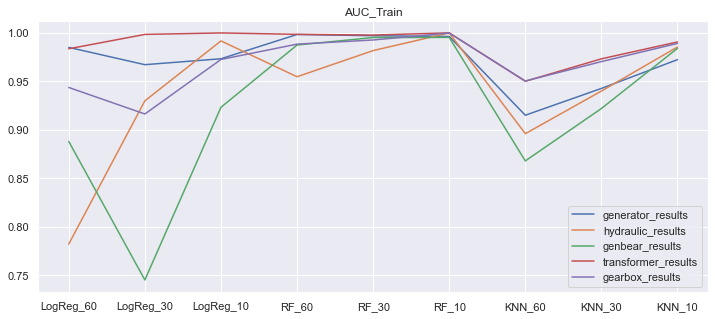

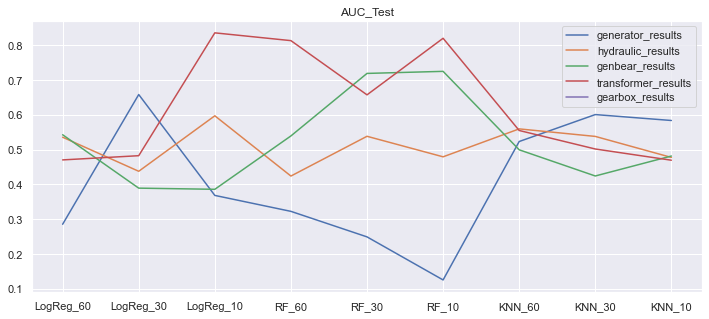

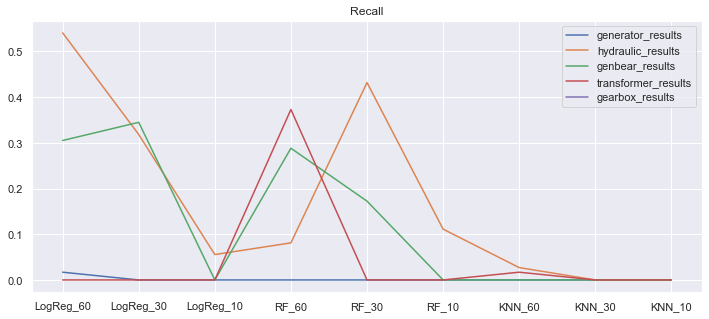

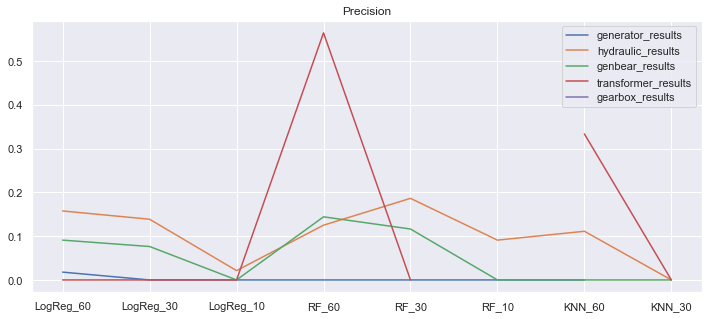

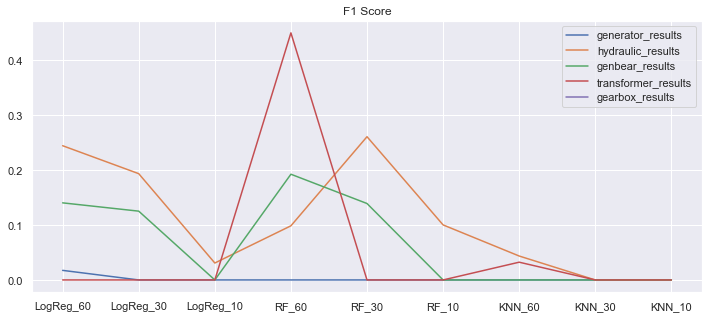

In [66]:
sns.set_theme()

fig, ax = plt.subplots(figsize=(12,5))

for i in dict_results_by_component.keys():
    dict_results_by_component[i].loc['AUC_Train', :].plot(label=i)
plt.legend()
plt.title('AUC_Train')
#plt.show()

fig, ax = plt.subplots(figsize=(12,5))


for l in dict_results_by_component.keys():
    dict_results_by_component[l].loc['AUC_Test', :].plot(label=l)
plt.legend()
plt.title('AUC_Test')
#plt.show()

fig, ax = plt.subplots(figsize=(12,5))


for i in dict_results_by_component.keys():
    dict_results_by_component[i].loc['Recall', :].plot(label=i)
plt.legend()
plt.title('Recall')
#plt.show()


fig, ax = plt.subplots(figsize=(12,5))


for i in dict_results_by_component.keys():
    dict_results_by_component[i].loc['Precision', :].plot(label=i)
plt.legend()
plt.title('Precision')
#plt.show()

fig, ax = plt.subplots(figsize=(12,5))


for i in dict_results_by_component.keys():
    dict_results_by_component[i].loc['F1 Score', :].plot(label=i)
plt.legend()
plt.title('F1 Score')
plt.show()

In [255]:
dict_results_by_component['generator_results']

,LogReg_60,LogReg_30,LogReg_10,RF_60,RF_30,RF_10,KNN_60,KNN_30,KNN_10
AUC_Train,0.995066,0.995507,0.992215,0.999998,0.999871,0.999753,0.866246,0.902861,0.943444
AUC_Test,0.267930,0.693135,0.322612,0.865283,0.818966,0.447612,0.515008,0.614125,0.610380
Accuracy,0.748387,0.821505,0.817204,0.877419,0.933333,0.976344,0.873118,0.937634,0.980645
Recall,0.016949,0.241379,0.000000,0.033898,0.034483,0.000000,0.000000,0.000000,0.000000
Specificity,0.854680,0.860092,0.833333,1.000000,0.993119,0.995614,1.000000,1.000000,1.000000
Precision,0.016667,0.102941,0.000000,1.000000,0.250000,0.000000,NaN,NaN,NaN
F1 Score,0.016807,0.144330,0.000000,0.065574,0.060606,0.000000,0.000000,0.000000,0.000000


In [259]:
dict_results_by_component.keys()

dict_keys(['generator_results', 'hydraulic_results', 'genbear_results', 'transformer_results', 'gearbox_results'])

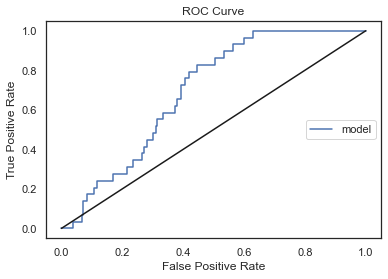

Predicted Class    0   1
Actual Class            
0                375  61
1                 22   7


{'AUC_Train': 0.9955067706196143,
 'AUC_Test': 0.6931350838342296,
 'Accuracy': 0.821505376344086,
 'Sensitivity': 0.2413793103448276,
 'Specificity': 0.8600917431192661,
 'Precision': 0.10294117647058823,
 'F1 Score': 0.14432989690721648,
 'Log Loss': 0.7378004671732987,
 'FBeta Score': 0.23820754716981135}

In [70]:

roc_curve_plot(df_test[target], pred_LogReg_test['y_test_prob'])
#roc_curve_plot(df_train[target], pred_LogReg_train['y_train_prob'])

conf_matrix (df_test[target].values,  pred_LogReg_test['y_test_pred'])

metrics (df_train[target], pred_LogReg_train['y_train_prob'], df_test[target], pred_LogReg_test['y_test_pred'], pred_LogReg_test['y_test_prob'])
     